In [ ]:
'''This script loads, explores, and visualizes the salary prediction datasets'''
   
    
__author__ = 'Seema Mishra'
__email__ = 'seema.mishra.phd@gmail.com'


## Import Packages

In [2]:
# Load basic libraries for analysis
import numpy as np
import pandas as pd




# visullizong missing vlaues in data set 
#import missingno as msno 

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#setting display options
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 500)
np.set_printoptions(linewidth =400)

# ignore warningsb
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# import ML libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from platform import python_version

# Check Python version
print(python_version())


3.7.6


## Define Data Class

***
This class defines the data and perform preprocessing.

In [3]:
class Data:
    def __init__(self, train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col):
        '''create train and test dataframe'''
        #create new copies instead of references
        self.cat_cols = list(cat_cols)
        self.num_cols = list(num_cols)
        self.feature_cols = cat_cols + num_cols
        self.target_col = target_col
        self.id_col = id_col
        self.label_encoders = {}
        self.train_df = self._create_train_df(train_feature_file, train_target_file)
        self.test_df = self._create_test_df(test_file)
#         print(self.train_df.head())
    
    def label_encode_df(self, df, cols):
        '''creates one label encoder for each column in the data object instance'''
        for col in cols:
            if col in self.label_encoders:
                #if label encoder already exits for col, use it
                self._label_encode(df, col, self.label_encoders[col])
            else:
                self._label_encode(df, col)
    
    def inverse_encode_df(self, df, cols):
        '''does inverse label encoding'''
        for col in cols:
            if col in self.label_encoders:
                self._inverse_label_encode(df, col)  
            else:
                raise ValueError("label_encoders must be define for each col before calling inverse_encode_df")

    def _label_encode(self, df, col, le=None):
        '''label encodes data'''
        if le:
            df[col] = le.transform(df[col])
        else:
            le = LabelEncoder()
            le.fit(df[col])
            df[col] = le.transform(df[col])
            self.label_encoders[col] = le
        
    def _inverse_label_encode(self, df, col):
        '''inverse label encodes data'''
        le = self.label_encoders[col]
        df[col] = le.inverse_transform(df[col])
 
    def _create_train_df(self, train_feature_df, train_target_df, preprocess=True, label_encode=True):
        '''loads and merges training data features and targets, preprocesses data, encodes data'''
        train_feature_df = self._load_data(train_feature_file)
        train_target_df = self._load_data(train_target_file)
        train_df = self._merge_dfs(train_feature_df, train_target_df)
        if preprocess:
            train_df = self._clean_data(train_df)
            train_df = self._shuffle_data(train_df)
        if label_encode:
            self.label_encode_df(train_df, self.cat_cols)
        return train_df
    
    def _create_test_df(self, test_file, label_encode=True):
        '''loads and label encodes test data'''
        test_df = self._load_data(test_file)
        if label_encode:
            self.label_encode_df(test_df, self.cat_cols)
        return test_df
        
    def _load_data(self, file):
        return pd.read_csv(file)
    
    def _merge_dfs(self, df1, df2, key=None, left_index=False, right_index=False):
        return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)
    
    def _clean_data(self, df):
        '''remove rows that contain salary <= 0 or duplicate job IDs'''
        df = df.drop_duplicates(subset='jobId')
        df = df[df.salary>0]
        return df
    
    def _shuffle_data(self, df):
         return shuffle(df).reset_index()

## Define Data Exploration Class
***
This class defines the data exploration functions.

In [62]:
class DataExploration:
    def __init__(self, data):
        self.data = data
        
    def plot_categories(self, col):
        '''creating distribution plot for categorical feturues'''
        fig = plt.gcf()
        fig.set_size_inches(8, 5)
        plt.xticks(rotation=45, 
        horizontalalignment='right',
        fontweight='bold',
        fontsize='small')
        plt.yticks(fontweight='bold',
        fontsize='small')
        grouped = data.train_df.groupby(col)['salary'].mean()\
        .sort_values()
        sns.boxplot(x = col, y = 'salary', data=data.train_df, order=grouped.index)
    
    def plot_numerical(self, col):
        fig = plt.gcf()
        fig.set_size_inches(8, 5)
        grouped = data.train_df.groupby(col)['salary'].mean()\
        .sort_values()
        std = data.train_df.groupby(col)['salary'].std()
        grouped.plot()
        plt.xticks(rotation=45)
        plt.ylabel('Salary')


    def correlation_heatMap(self, data): 
        '''creating a correlation heatmap using heatmap'''
        corr = data.train_df.corr()
        _ , ax = plt.subplots( figsize =( 8 , 8 ) )
        cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
        _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 })
    

## Define Feature Generator Class
***
This class defines to generate features 

In [4]:
class FeatureGenerator:
    def __init__(self, data):
        '''initializes class and creates groupby object for data'''
        self.data = data
        #able to generate features for new companies, but less accurate
        #self.cat_cols = ['jobType', 'degree', 'major', 'industry']
        self.cat_cols = data.cat_cols
        self.groups = data.train_df.groupby(self.cat_cols)
        
    def add_group_stats(self):
        '''adds group statistics to data stored in data object'''
        #get group stats
        group_stats_df = self._get_group_stats()
        group_stats_df.reset_index(inplace=True)
        #print(group_stats_df)
  
        #merge derived columns to original df
        self.data.train_df = self._merge_new_cols(self.data.train_df, group_stats_df, self.cat_cols, fillna=True)
        self.data.test_df = self._merge_new_cols(self.data.test_df, group_stats_df, self.cat_cols, fillna=True)      
        
        #update column lists
        group_stats_cols = ['group_mean', 'group_max', 'group_min', 'group_std', 'group_median']
        self._extend_col_lists(self.data, cat_cols=group_stats_cols)  
        
    def _get_group_stats(self):
        '''calculates group statistics'''
        target_col = self.data.target_col
        group_stats_df = pd.DataFrame({'group_mean': self.groups[target_col].mean()})
        group_stats_df['group_max'] = self.groups[target_col].max()
        group_stats_df['group_min'] = self.groups[target_col].min()
        group_stats_df['group_std'] = self.groups[target_col].std()
        group_stats_df['group_median'] = self.groups[target_col].median()
        return group_stats_df
        
    def _merge_new_cols(self, df, new_cols_df, keys, fillna=False):
        '''merges engineered features with original df'''
        df = pd.merge(df, new_cols_df, on=keys, how='left')
        if fillna:
            df.fillna(0, inplace=True)
        return df
        
    def _extend_col_lists(self, data, cat_cols=[], num_cols=[]):
        '''addes engineered feature cols to data col lists'''
        data.num_cols.extend(num_cols)
        data.cat_cols.extend(cat_cols)
        data.feature_cols.extend(num_cols + cat_cols)

## Define Model Container Class
***

In [15]:
class ModelContainer:
    def __init__(self, models=[]):#, default_num_iters=10, verbose_lvl=0):
        '''initializes model list and dicts'''
        self.models = models
        self.best_model = None
        self.predictions = None
        self.mean_mse = {}
        #self.default_num_iters = default_num_iters
        #self.verbose_lvl = verbose_lvl
        
    def add_model(self, model):
        self.models.append(model)
  # Cross Validation
    def cross_validate(self, data, k=5, num_procs=1):
        '''cross validate models using given data'''
        feature_df = data.train_df[data.feature_cols]
        target_df = data.train_df[data.target_col]
        for model in self.models:
            neg_mse = cross_val_score(model, feature_df, target_df, cv=k, n_jobs=num_procs, scoring='neg_mean_squared_error')
            self.mean_mse[model] = -1.0*np.mean(neg_mse)
#     # Hyper Parameter Tuning 
        
          
    def select_best_model(self):
        '''select model with lowest mse'''
        self.best_model = min(self.mean_mse, key=self.mean_mse.get)
        
    def best_model_fit(self, features, targets):
        '''fits best model'''
        self.best_model.fit(features, targets)
    
    def best_model_predict(self, features):
        '''scores features using best model'''
        self.predictions = self.best_model.predict(features)
        
    def save_results(self):
        pass
    
    @staticmethod
    def get_feature_importance(model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            #print(cols)
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"

    def print_summary(self):
        feature_df = data.train_df[data.feature_cols]
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        for model in models.mean_mse:
            print('\n', model, '- MSE:', models.mean_mse[model])
        print('\nBest Model:\n', models.best_model)
        print('\nMSE of Best Model\n', models.mean_mse[models.best_model])
#         feature_importances = self.models.get_feature_importance(models.best_model, feature_df)
#         print('\nFeature Importances\n', feature_importances)
        
#         feature_importances.plot.bar()
#         plt.show()

## Define Parameters needed to create and run models
***

In [6]:
#define number of processors to use for parallel runs
num_procs = 4

#set verbose level for models
verbose_lvl = 0

#define input files
train_feature_file = 'data/train_features.csv'
train_target_file = 'data/train_salaries.csv'
test_file = 'data/test_features.csv'

#define variables
cat_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_cols = ['yearsExperience', 'milesFromMetropolis']
target_col = 'salary'
id_col = 'jobId'

#turn feature engineering on/off
engineer_features = True

# Part 1: Data Exploration

In [18]:
# Create instance of class with no data preprocessing 
data_noprep = Data(train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col)

### Examine Data

In [32]:
data_noprep.train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [33]:
data_noprep.test_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,27,5,2,7,3,22,73
1,JOB1362685407688,5,4,4,7,0,20,47
2,JOB1362685407689,2,2,3,0,3,17,9
3,JOB1362685407690,14,5,2,7,4,14,96
4,JOB1362685407691,30,4,1,0,4,10,44


#### use .info to see and length and datatype

In [35]:
data_noprep.train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [36]:
data_noprep.test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  int64 
 2   jobType              1000000 non-null  int64 
 3   degree               1000000 non-null  int64 
 4   major                1000000 non-null  int64 
 5   industry             1000000 non-null  int64 
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 61.0+ MB


#### Check for shape of the data

print("shape of train set:", data_noprep.train_df.shape)
print("shape of target set:", data_noprep.test_df.shape)

#### Check for duplicates

print("Number of duplicates in train features:", data_noprep.train_df.duplicated().sum())
print("Number of duplicates in target features:", data_noprep.train_df.duplicated().sum())

#### Data Quality Analysis

In [69]:
# In Training Data
total = data_noprep.train_df.isnull().sum().sort_values(ascending = False)
percent = round(data_noprep.train_df.isnull().sum().sort_values(ascending = False)/len(data_noprep.train_df)*100,2)
pd.concat([total, percent], axis=1, keys=['Total','Percent'])

,Total,Percent
salary,0,0.0
milesFromMetropolis,0,0.0
yearsExperience,0,0.0
industry,0,0.0
major,0,0.0
degree,0,0.0
jobType,0,0.0
companyId,0,0.0
jobId,0,0.0


No data missing in training data.

In [70]:
# In Testing Data
total = data_noprep.test_df.isnull().sum().sort_values(ascending = False)
percent = round(data_noprep.test_df.isnull().sum().sort_values(ascending = False)/len(data_noprep.train_df)*100,2)
pd.concat([total, percent], axis=1, keys=['Total','Percent'])

,Total,Percent
milesFromMetropolis,0,0.0
yearsExperience,0,0.0
industry,0,0.0
major,0,0.0
degree,0,0.0
jobType,0,0.0
companyId,0,0.0
jobId,0,0.0


No data missing in testing data.

#### Numerical and Categorical data summarization

In [41]:
data_noprep.train_df.describe(include = [np.number]) # for numerical

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [43]:
data_noprep.train_df.describe(include = ['O']) # for categorical

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684884207,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


#### use IQR rule to identify potential outlier

In [47]:
stat = data_noprep.train_df.salary.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bound of suspected outliers are {} and {}.' .format(upper, lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bound of suspected outliers are 220.5 and 8.5.


#### Let's examine outliers in details

In [50]:
# Find all records below lower bound
data_noprep.train_df[data_noprep.train_df.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


**Summary**
***
- It looks like ...
    - It make no sense for job type manager having doctoral degree or Vice President has salary $0.
    - It seems the data is missing or incorrectly recorded. 

In [59]:
# visual.correlation_heatMap(data_noprep)

In [52]:
# Find all records above upper  bound
data_noprep.train_df.loc[data_noprep.train_df.salary > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

**Summary**
***

  - salary for job type CEO, CFO, Vice President manager and for senior seems to be reasonale to have greater than
  $220K.
  - Job type Junior role and salary about $220K seems to have corrupt data but needs to be investigated further. 
    
    Lets find out the more details of record who has jobtype as a Junior and high salary.

In [54]:
data_noprep.train_df[(data_noprep.train_df.salary > 220.5) & (data_noprep.train_df.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


**Summary**
***
- It looks like ...
    - The high salary potential outlier seems to be legitimate.
    - Idustires that are well known for high salaries(oil, finance). 
    

### Data Visualization

In [65]:
# Create data exploration class instance 
visual =DataExploration(data_noprep)

#### Plor Salary variable

Text(0.5, 1.0, 'Distribution Plot')

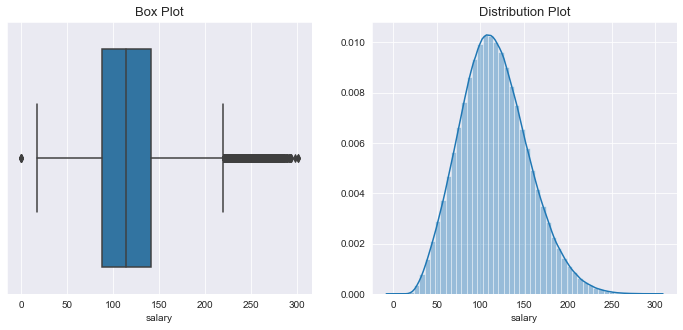

In [66]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,5),ncols=2)
ax1 = sns.boxplot(data_noprep.train_df.salary, ax = ax[0]);
ax2 = sns.distplot(data_noprep.train_df.salary, ax = ax[1]);
ax1.set_title("Box Plot", fontsize = 13)
ax2.set_title('Distribution Plot',  fontsize = 13)

**Summary**
***
- It looks like ...
    - distribution of salary feature follows a normal(Guaussian)distribution.
    - there seems to be an outlier after salary range around 220K and 0 also is a outlier.

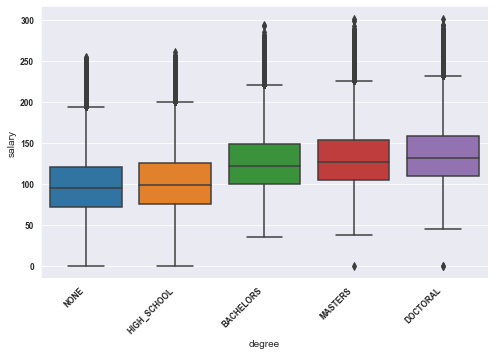

In [57]:
visual.plot_categories('degree')

**Summary**
***
- We can see 
    - Doctoral and Master degree cadidates have high salary.
      

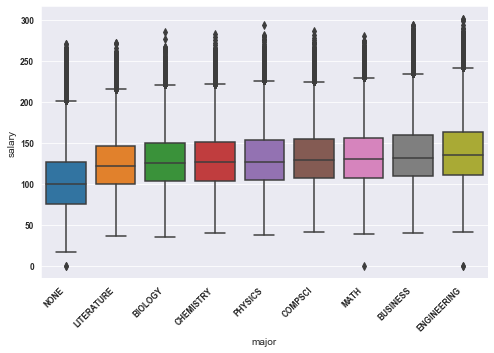

In [58]:
visual.plot_categories('major')

**Summary**
***
- We can see 
    - There is very slight difference of salaries in different majors.

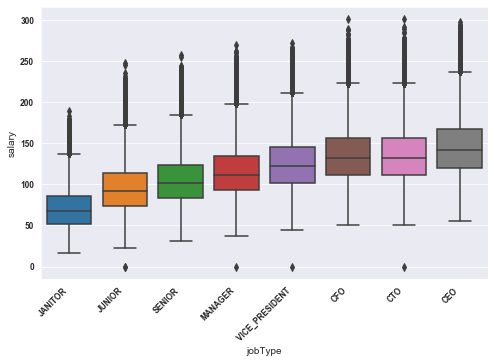

In [60]:
visual.plot_categories('jobType')

**Summary**
***
- We can see 
    - Higher the position of employee higher would be the salary.

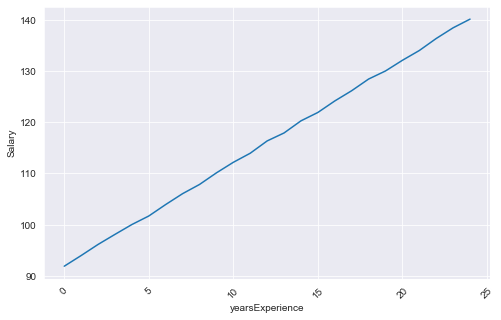

In [67]:
visual.plot_numerical('yearsExperience')

**Summary**
***
- It clearly explain 
    - salary commensurate with experience. More the number of year of experience higher would be the salary.
    - Graph also exbhit the strong positive correlation between number of experience and salary. 

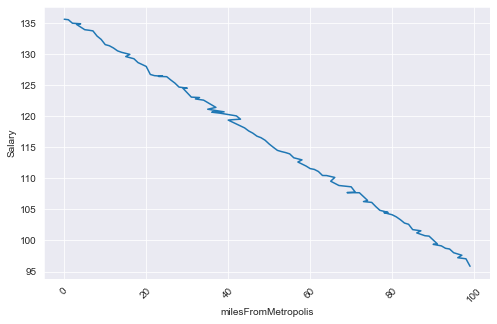

In [68]:
visual.plot_numerical('milesFromMetropolis')

**Summary**
***

- Generally places far from metropolis have relatively low average salaries, which might be reson for financial benefits of cheaper housing, groceries, and other expenses.

- It also exhibit the the salary is negativiely correlated with milesFromMetropolis. 


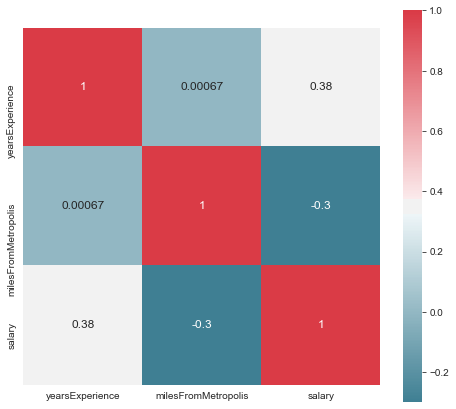

In [75]:
visual.correlation_heatMap(data_noprep)

**Summary**
***

- Salary and YearOfExperience features are postiviely correlated.

- Salary and milesFromMetropolis are negatively correlated. 

# Part 2: Data Preprocessing 

Create a Class data instance with Data Preprocessing. 

In [16]:
data_prep = Data(train_feature_file, train_target_file, test_file, cat_cols, num_cols, target_col, id_col)

In [9]:
data_prep.train_df.head() # After data preprocessing 

,index,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,829710,JOB1362685237397,40,3,2,7,6,24,1,162
1,846594,JOB1362685254281,49,7,0,5,0,1,42,114
2,587280,JOB1362684994967,14,7,3,7,1,20,50,143
3,392804,JOB1362684800491,22,5,0,2,1,21,5,179
4,148725,JOB1362684556412,13,0,0,0,4,11,49,180


# Part 3: Feature Engineering 

In [18]:
if engineer_features:
    feature_generator = FeatureGenerator(data_prep)
    feature_generator.add_group_stats()

ValueError: cannot insert group_median, already exists

# Part 4: Model Building and Validation

### Create Model Container

In [20]:
#create model container
models = ModelContainer()
data = data_prep
#create models -- hyperparameter tuning already done by hand for each model
models.add_model(LinearRegression())
models.add_model(RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=15, min_samples_split=80, \
                                       max_features=8, verbose=verbose_lvl))
models.add_model(GradientBoostingRegressor(n_estimators=40, max_depth=7, loss='ls', verbose=verbose_lvl))
models.add_model(Lasso(alpha = 0.2))
models.add_model(Ridge(alpha=0.2))

In [74]:
models

### Cross Validate Model and select best Model

In [ ]:
 #validate models, then select, fit, and score test data with best model
models.cross_validate(data, k=5, num_procs=num_procs)
models.select_best_model()
models.best_model_fit(data.train_df[data.feature_cols], data.train_df[data.target_col])
models.best_model_predict(data.test_df[data.feature_cols])

### Sumarize Results

In [13]:
models.print_summary()


Model Summaries:


 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) - MSE: 358.1722422586834

 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=80, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=4, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) - MSE: 312.90723690804236

 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_sampl

AttributeError: 'list' object has no attribute 'get_feature_importance'

        companyId  jobType  degree  major  industry  yearsExperience  \
0              40        3       2      7         6               24   
1              49        7       0      5         0                1   
2              14        7       3      7         1               20   
3              22        5       0      2         1               21   
4              13        0       0      0         4               11   
...           ...      ...     ...    ...       ...              ...   
999990         42        1       1      1         4               16   
999991         18        5       1      2         3               24   
999992          0        2       4      7         6               22   
999993          1        7       0      8         2                0   
999994         44        4       1      1         1               22   

        milesFromMetropolis  group_mean  group_max  group_min  group_std  \
0                         1   76.514925        162         

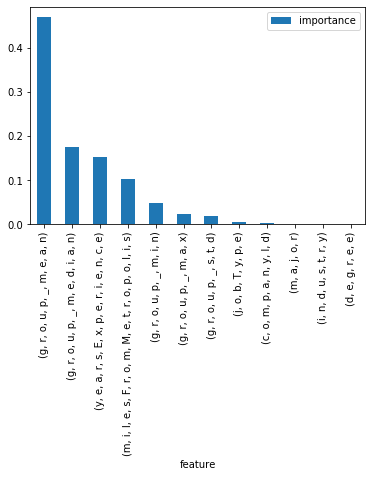

In [14]:
# K=10 and k=5 gives same result
feature_importances = models.get_feature_importance(models.best_model, data.train_df[data.feature_cols])
print('\nFeature Importances\n', feature_importances)
        
feature_importances.plot.bar()
plt.show()

In [66]:
feature_importances

,importance
feature,
"(g, r, o, u, p, _, m, e, a, n)",0.443028
"(g, r, o, u, p, _, m, e, d, i, a, n)",0.199704
"(y, e, a, r, s, E, x, p, e, r, i, e, n, c, e)",0.151661
"(m, i, l, e, s, F, r, o, m, M, e, t, r, o, p, o, l, i, s)",0.102425
"(g, r, o, u, p, _, m, i, n)",0.065376
"(g, r, o, u, p, _, s, t, d)",0.018246
"(g, r, o, u, p, _, m, a, x)",0.013759
"(c, o, m, p, a, n, y, I, d)",0.002319
"(j, o, b, T, y, p, e)",0.001171


In [71]:
data.train_df[data.feature_cols].head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,group_mean,group_max,group_min,group_std,group_median
0,11,0,1,0,2,10,11,161.142857,206,120,31.397604,159.0
1,1,7,1,0,0,22,59,118.888889,147,86,22.485798,128.0
2,54,5,4,7,6,11,22,104.910714,172,60,28.920126,100.0
3,19,6,3,3,6,22,97,127.000000,172,101,23.916521,125.0
4,19,4,2,7,6,19,42,91.196970,139,43,23.170419,93.0


In [ ]:
models